In [ ]:
!pip install transformers datasets torch scikit-learn pandas numpy seaborn prophet mlxtend

## Importing Librarires

In [ ]:
import io
import pandas as pd                # data manipulation
import numpy as np                 # numerical operations
import seaborn as sns              # statistical plotting
import matplotlib.pyplot as plt    # visualizations
from google.colab import files     # file upload/download
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler  # feature scaling
from sklearn.cluster import KMeans, AgglomerativeClustering  # clustering algorithms
from sklearn.metrics import silhouette_score  # clustering evaluation
from sklearn.mixture import GaussianMixture  # GMM clustering
from sklearn.decomposition import PCA       # dimensionality reduction
from prophet import Prophet                 # time series forecasting
from sklearn.pipeline import Pipeline        # modeling pipeline
from sklearn.ensemble import RandomForestRegressor  # regression model
from sklearn.model_selection import train_test_split  # train/test split
from sklearn.metrics import r2_score, mean_absolute_error  # regression metrics
from mlxtend.frequent_patterns import apriori, association_rules  # association rules
from mlxtend.preprocessing import TransactionEncoder          # basket encoding

# 1. Data Loading
### Data Loading

In [ ]:
# ── 1. Data Loading ────────────────────────────────────
uploaded = files.upload()
filename = list(uploaded.keys())[0]  # uploaded filename
try:
    df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='utf-8')  # read CSV
except UnicodeDecodeError:
    df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1')

# Convert 'ORDERDATE' to datetime objects
df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])

Saving sales_data_sample (1).csv to sales_data_sample (1) (4).csv


# 2. Intial Exploration and Data Analysis

### Numeric Summaries

In [ ]:
# ── 2. Exploratory Data Analysis ───────────────────────
# Numeric summaries
print("=== Numeric Summary ===")
print(df[['SALES', 'QUANTITYORDERED', 'PRICEEACH']].describe())

# Categorical counts
for col in ['PRODUCTLINE', 'COUNTRY', 'DEALSIZE']:
    print(f"\n=== Value Counts for {col} ===")
    print(df[col].value_counts())

# Distribution plots
for col in ['SALES', 'QUANTITYORDERED', 'PRICEEACH']:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

### Categorical Value Counts and Sales Analysis


In [ ]:
# Sales by deal size and country/product
plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x='DEALSIZE',
    y='SALES',
    hue='COUNTRY',
    estimator=sum,
    errorbar=None # Changed ci to errorbar
)
plt.title('Total Sales by Deal Size and Country')
plt.xlabel('Deal Size')
plt.ylabel('Total Sales')
plt.legend(bbox_to_anchor=(1.05, 1), title='Country')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(
    data=df,
    x='DEALSIZE',
    y='SALES',
    hue='PRODUCTLINE',
    estimator=sum,
    errorbar=None # Changed ci to errorbar
)
plt.title('Total Sales by Deal Size and Product Line')
plt.xlabel('Deal Size')
plt.ylabel('Total Sales')
plt.legend(bbox_to_anchor=(1.05, 1), title='Product Line')
plt.tight_layout()
plt.show()

# Sales over time
df['YearMonth'] = df['ORDERDATE'].dt.to_period('M').astype(str)  # Year-Month string
monthly = df.groupby('YearMonth')['SALES'].sum().reset_index()
plt.figure(figsize=(14, 5))
sns.lineplot(data=monthly, x='YearMonth', y='SALES', marker='o')
plt.xticks(rotation=45); plt.title('Monthly Total Sales'); plt.tight_layout(); plt.show()

# Sales by country
country_sales = df.groupby('COUNTRY')['SALES'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(data=country_sales, x='COUNTRY', y='SALES')
plt.xticks(rotation=45); plt.title('Total Sales by Country'); plt.tight_layout(); plt.show()


# 3. Data Preprocessing and Feature Engineering

### Data Quality Checks and Handling Missing Values

In [ ]:
# Drop secondary columns
for col in ['PHONE', 'POSTALCODE', 'ADDRESSLINE2', 'TERRITORY']:
    if col in df.columns:
        df.drop(columns=col, inplace=True)
# Fill missing state
df['STATE'] = df.get('STATE', pd.Series()).fillna('Unknown')  # STATE: customer state or Unknown

# Extract time features
# year, month: extracted from ORDERDATE
df['year'] = df['ORDERDATE'].dt.year
df['month'] = df['ORDERDATE'].dt.month

# Customer-level aggregates
# total_rev_per_customer: sum of sales per customer
# order_count_per_customer: count of unique orders
df['total_rev_per_customer'] = df.groupby('CUSTOMERNAME')['SALES'].transform('sum')
df['order_count_per_customer'] = df.groupby('CUSTOMERNAME')['ORDERNUMBER'].transform('nunique')

# Encode DEALSIZE ordinally
deal_map = {'Small': 1, 'Medium': 2, 'Large': 3}
df['DEALSIZE_ord'] = df['DEALSIZE'].map(deal_map)  # DEALSIZE_ord: ordinal encoding of deal size

# One-hot encode categorical
df = pd.get_dummies(df, columns=[c for c in ['PRODUCTLINE', 'COUNTRY', 'STATUS'] if c in df.columns], drop_first=True)

# Save cleaned data (Optional - Remove comment to process)
# df.to_csv('cleaned_sales_data.csv', index=False)
# files.download('cleaned_sales_data.csv')  # download cleaned dataset

# 4. Customer Segmentation (RFM + Clustering) - KMeans (Partially passed)

### KMeans Algo

In [ ]:
#from sklearn.preprocessing import MinMaxScaler
#from sklearn.cluster       import AgglomerativeClustering
#from sklearn.metrics       import silhouette_score
#import numpy as np
#import pandas as pd

# 1️⃣ Build RFM+ with AvgDealSize
#snapshot = df['ORDERDATE'].max() + pd.Timedelta(days=1)
#rfm = df.groupby('CUSTOMERNAME').agg({
#    'ORDERDATE':   lambda x: (snapshot - x.max()).days,
#    'ORDERNUMBER': 'nunique',
#    'SALES':       'sum'
#}).rename(columns={
#    'ORDERDATE':   'Recency',
#    'ORDERNUMBER': 'Frequency',
#    'SALES':       'Monetary'
#})
# Your extra customer features
#rfm['TotalRev']     = rfm['Monetary']
#rfm['AvgDealSize']  = df.groupby('CUSTOMERNAME')['DEALSIZE_ord'].mean()

# 2️⃣ MinMax scale
#features = ['Recency','Frequency','Monetary','TotalRev','AvgDealSize']
#X = MinMaxScaler().fit_transform(rfm[features])

# 3️⃣ Ward Hierarchical for k=3
#k = 3
#labels = AgglomerativeClustering(n_clusters=k, linkage='ward').fit_predict(X)
#score  = silhouette_score(X, labels)

# 4️⃣ Merge & report
#rfm['Cluster_3'] = labels
#df = df.merge(rfm[['Cluster_3']], on='CUSTOMERNAME', how='left')
#print(f"Silhouette (k=3): {score:.3f}")
#print("Cluster sizes:", np.bincount(labels))


# 4. Customer Segmentation (RFM + Clustering) - AgglomerativeClustering (Best results)

### AgglomerativeClustering with k = 3

In [ ]:
# RFM calculation
snapshot = df['ORDERDATE'].max() + pd.Timedelta(days=1)  # snapshot date for recency calc
rfm = df.groupby('CUSTOMERNAME').agg({
    'ORDERDATE':   lambda x: (snapshot - x.max()).days,  # Recency
    'ORDERNUMBER': 'nunique',                           # Frequency
    'SALES':       'sum',                               # Monetary
    'CUSTOMERNAME':'size'                               # OrderCount: total orders
}).rename(columns={
    'ORDERDATE':    'Recency',
    'ORDERNUMBER':  'Frequency',
    'SALES':        'Monetary',
    'CUSTOMERNAME': 'OrderCount'
})
# Additional features
rfm['TotalRev'] = rfm['Monetary']  # TotalRev: same as Monetary sum

# Scaling for clustering
features = ['Recency', 'Frequency', 'Monetary', 'TotalRev']
X = StandardScaler().fit_transform(rfm[features])  # standardized RFM+ features

# Hierarchical clustering k=3
k = 3
labels = AgglomerativeClustering(n_clusters=k, linkage='ward')\
         .fit_predict(X)
score = silhouette_score(X, labels)
print(f"Silhouette score for k={k}: {score:.3f}")

# Merge clusters back to main df
rfm['Cluster_Hier3'] = labels  # Cluster_Hier3: hierarchical cluster labels
df = df.drop(columns=[c for c in df.columns if c.startswith('Cluster_Hier')], errors='ignore')  # remove old labels
df = df.merge(rfm[['Cluster_Hier3']], on='CUSTOMERNAME', how='left')

# Quick check
print("Cluster sizes:", rfm['Cluster_Hier3'].value_counts())

Silhouette score for k=3: 0.553
Cluster sizes: Cluster_Hier3
0    78
2    12
1     2
Name: count, dtype: int64


GMM cluster profiles:
              Recency  Frequency  Monetary
Cluster_GMM                              
0              126.9        3.3  104459.5
1                2.0       21.5  783576.1
2              326.7        2.0   69797.3


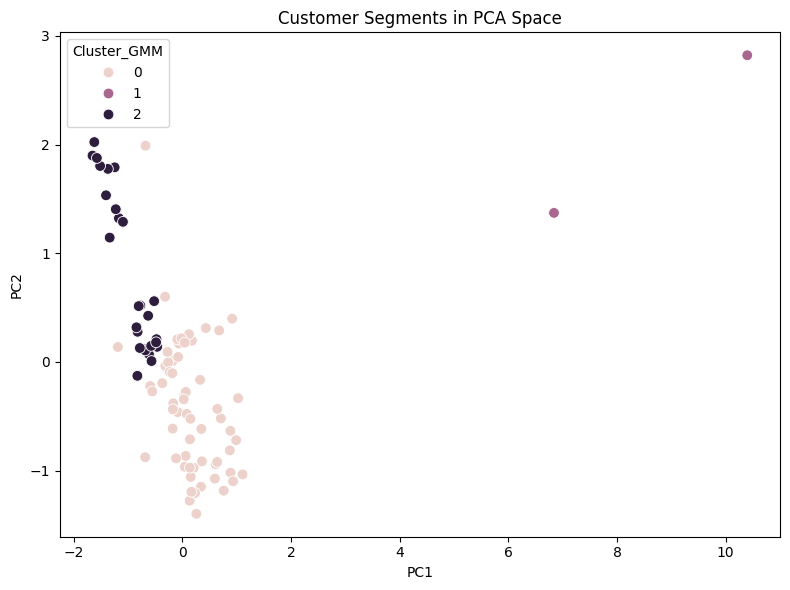

In [ ]:
# GMM clustering
scaled_for_gmm = StandardScaler().fit_transform(rfm[['Recency','Frequency','Monetary']])
gmm = GaussianMixture(n_components=k, random_state=42).fit(scaled_for_gmm)
rfm['Cluster_GMM'] = gmm.predict(scaled_for_gmm)  # Cluster_GMM: Gaussian Mixture labels
print("GMM cluster profiles:\n", rfm.groupby('Cluster_GMM')[['Recency','Frequency','Monetary']].mean().round(1))

# PCA for visualization
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(scaled_for_gmm)
rfm['PC1'], rfm['PC2'] = pc[:,0], pc[:,1]

plt.figure(figsize=(8,6))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_GMM', data=rfm, s=60)
plt.title('Customer Segments in PCA Space'); plt.tight_layout(); plt.show()

# Merge clusters back to main df
df = df.merge(rfm[['Cluster_Hier3','Cluster_GMM']], on='CUSTOMERNAME', how='left')

### Visualizing the customer segments in reduced dimensions and in feature‐space

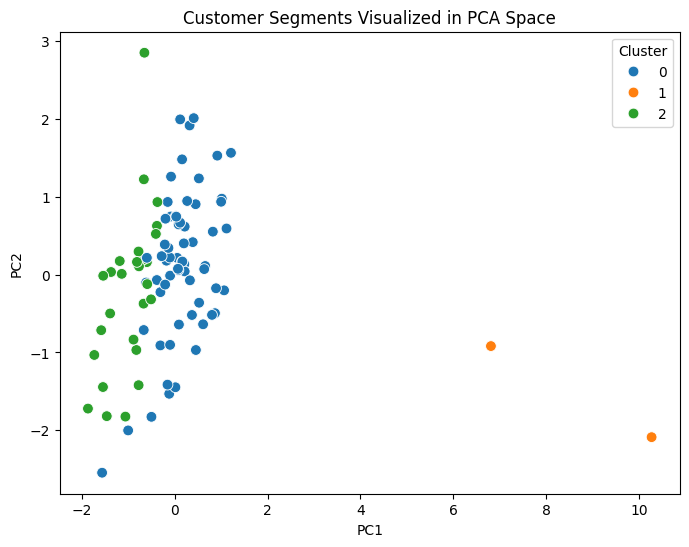

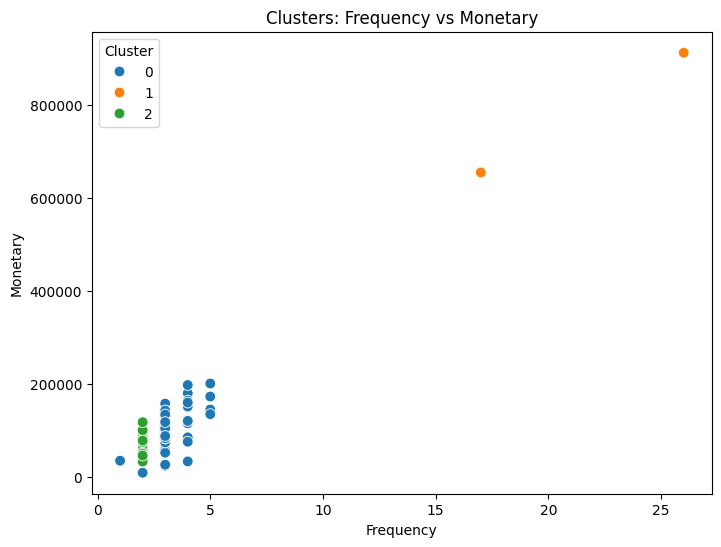

In [ ]:

# Prepare PCA projection

# Recalculate AvgDealSize and add to rfm DataFrame
# Assuming 'DEALSIZE_ord' was created earlier and is available in df
if 'DEALSIZE_ord' in df.columns:
    rfm['AvgDealSize'] = df.groupby('CUSTOMERNAME')['DEALSIZE_ord'].mean()
else:
    print("Warning: 'DEALSIZE_ord' not found in df. Skipping AvgDealSize calculation.")
    # If 'DEALSIZE_ord' is not available, you might need to adjust the features list

features = ['Recency', 'Frequency', 'Monetary'] # Start with RFM features
if 'AvgDealSize' in rfm.columns: # Add AvgDealSize only if it was successfully created
    features.append('AvgDealSize')
else:
     print("PCA will be performed without AvgDealSize due to missing data.")


X = StandardScaler().fit_transform(rfm[features])
pca = PCA(n_components=2, random_state=42)
pc = pca.fit_transform(X)
rfm['PC1'], rfm['PC2'] = pc[:,0], pc[:,1]

# 2️⃣ PCA scatter plot
plt.figure(figsize=(8,6))
# Use 'Cluster_GMM' as the hue, as 'Cluster_Refined' is not present
sns.scatterplot(x='PC1', y='PC2', hue='Cluster_GMM', data=rfm, palette='tab10', s=60)
plt.title('Customer Segments Visualized in PCA Space')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')
plt.show()

# 3️⃣ Feature-space scatter plot (Frequency vs Monetary)
plt.figure(figsize=(8,6))
# Use 'Cluster_GMM' as the hue
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster_GMM', data=rfm, palette='tab10', s=60)
plt.title('Clusters: Frequency vs Monetary')
plt.xlabel('Frequency')
plt.ylabel('Monetary')
plt.legend(title='Cluster')
plt.show()

### Diagnostics—if one cluster’s average silhouette is very low, it suggests that those customers may be poorly separated

In [ ]:
from sklearn.metrics import silhouette_samples
scores = silhouette_samples(X, rfm['Cluster_GMM'])
rfm['Silhouette'] = scores
print(rfm.groupby('Cluster_GMM')['Silhouette'].mean().round(2))

Cluster_GMM
0    0.28
1    0.54
2    0.22
Name: Silhouette, dtype: float64


#  5. Time Series Forecasting

In [ ]:
# ── 5. Time Series Forecasting ─────────────────────────

# Monthly sales
df['YearMonth'] = df['ORDERDATE'].dt.to_period('M').dt.to_timestamp()
monthly = df.groupby('YearMonth')['SALES'].sum().reset_index().rename(columns={'YearMonth':'ds','SALES':'y'})

# Prophet model
ts_model = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
ts_model.fit(monthly)
future = ts_model.make_future_dataframe(periods=6, freq='ME')  # forecast next 6 months
forecast = ts_model.predict(future)

INFO:prophet:n_changepoints greater than number of observations. Using 22.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqzn8ql8z/o2q2cof9.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqzn8ql8z/e6mbs_fg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91984', 'data', 'file=/tmp/tmpqzn8ql8z/o2q2cof9.json', 'init=/tmp/tmpqzn8ql8z/e6mbs_fg.json', 'output', 'file=/tmp/tmpqzn8ql8z/prophet_model3nblpeod/prophet_model-20250710033940.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
03:39:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
03:39:41 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


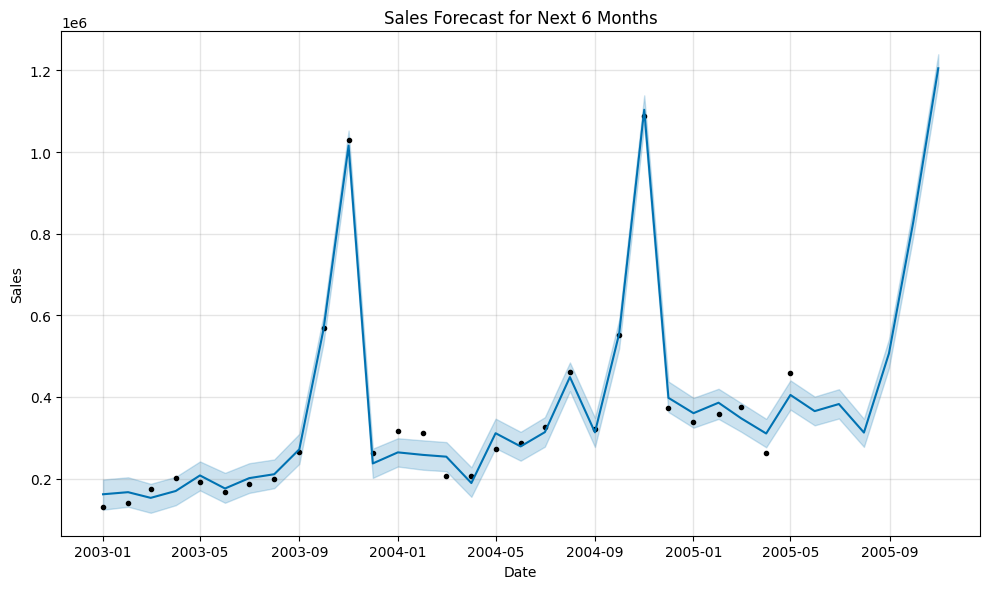

🔝 Top Predicted Sales Months:
           ds          yhat
34 2005-10-31  1.205186e+06
33 2005-09-30  8.275809e+05
32 2005-08-31  5.067320e+05
30 2005-06-30  3.825878e+05
29 2005-05-31  3.652352e+05
31 2005-07-31  3.127090e+05


In [ ]:
# === 📈 Forecast Plot ===
fig = ts_model.plot(forecast)
plt.title("Sales Forecast for Next 6 Months")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()

# === 🔍 Identify High-Conversion Months ===
# Show only future predictions
future_forecast = forecast[forecast['ds'] > monthly['ds'].max()]
top_months = future_forecast[['ds', 'yhat']].sort_values('yhat', ascending=False)

print("🔝 Top Predicted Sales Months:")
print(top_months)


# 6. Predictive Modeling Pipeline

In [ ]:
# === 🛒 Convert Data to Basket Format for Apriori ===
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Group product names by order - Use 'PRODUCTCODE' instead of 'PRODUCTLINE'
baskets = df.groupby('ORDERNUMBER')['PRODUCTCODE'].apply(list).values.tolist()

# Transform to binary matrix
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
basket_df = pd.DataFrame(te_ary, columns=te.columns_)

# === 📊 Find Frequent Itemsets ===
frequent_itemsets = apriori(basket_df, min_support=0.02, use_colnames=True)

# === 🔗 Generate Association Rules ===
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)
rules = rules.sort_values(by='lift', ascending=False)

# === 🔍 View Top Rules ===
print("📦 Top Product Association Rules:")
display(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(5))

📦 Top Product Association Rules:


,antecedents,consequents,support,confidence,lift
1974418,"(S18_3856, S700_1691, S700_2466, S700_3167, S2...","(S50_1341, S24_2841, S700_2047)",0.022801,1.0,43.857143
2581979,"(S18_3856, S700_4002, S50_1341, S24_3949)","(S700_1691, S700_2466, S24_2841, S700_2047, S7...",0.022801,1.0,43.857143
2389057,"(S700_3167, S700_1691, S24_2841, S700_2047)","(S18_3856, S700_2466, S24_3949, S50_1341, S24_...",0.022801,1.0,43.857143
2581941,"(S18_3856, S700_1691, S24_3420, S24_3949)","(S700_2466, S24_2841, S700_2047, S700_4002, S7...",0.022801,1.0,43.857143
2389059,"(S700_1691, S24_2841, S700_2047, S24_3420)","(S18_3856, S700_2466, S24_3949, S700_3167, S50...",0.022801,1.0,43.857143


In [ ]:
# === 💳 Customer Lifetime Value Prediction (Step 7) ===
features = ['Recency', 'Frequency', 'OrderCount']
target = 'Monetary'

X = rfm[features]
y = rfm[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Train model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate model
y_pred = rf.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"📊 R² Score: {r2:.2f}")
print(f"📉 Mean Absolute Error: {mae:.2f}")

# Predict and rank customers
rfm['LTV_Predicted'] = rf.predict(rfm[features])
top_customers = rfm[['LTV_Predicted']].sort_values(by='LTV_Predicted', ascending=False)

print("\n🔝 Top 10 High-Value Customers (Predicted LTV):")
display(top_customers.head(10))

📊 R² Score: 0.93
📉 Mean Absolute Error: 21546.48

🔝 Top 10 High-Value Customers (Predicted LTV):


,LTV_Predicted
CUSTOMERNAME,
Euro Shopping Channel,613029.0887
Mini Gifts Distributors Ltd.,540682.5128
La Rochelle Gifts,259185.0026
"Australian Collectors, Co.",192840.1679
Muscle Machine Inc,187872.8468
Rovelli Gifts,177842.8727
Land of Toys Inc.,175676.5494
"AV Stores, Co.",175282.7905
Souveniers And Things Co.,164154.0105


/tmp/ipython-input-77-459407912.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top10.index, y='LTV_Predicted', data=top10, palette='viridis')


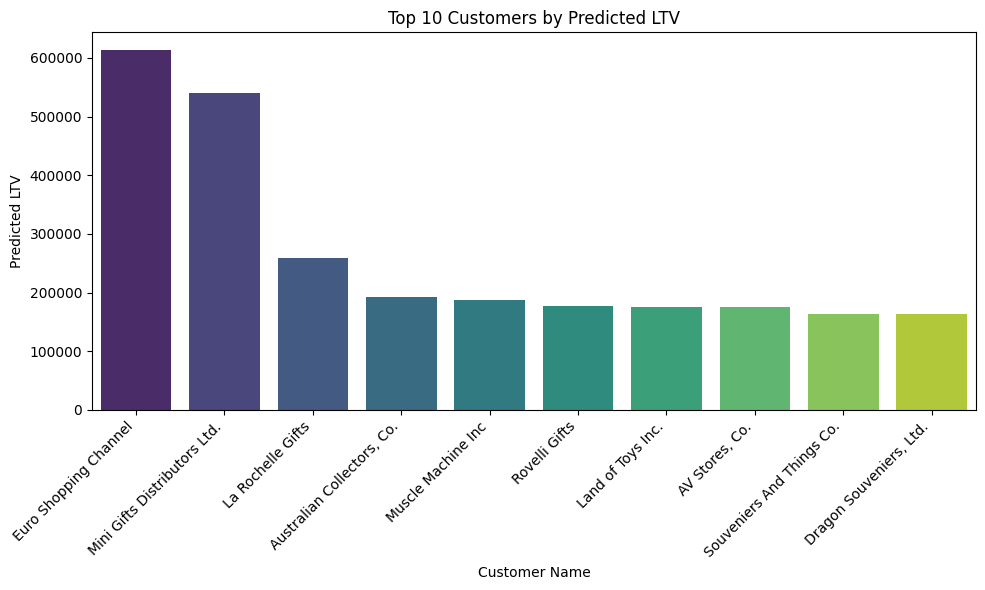

In [ ]:
# Visualize the top 10 customers by predicted LTV
plt.figure(figsize=(10, 6))
sns.barplot(x=top10.index, y='LTV_Predicted', data=top10, palette='viridis')
plt.title('Top 10 Customers by Predicted LTV')
plt.xlabel('Customer Name')
plt.ylabel('Predicted LTV')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()